<a href="https://colab.research.google.com/github/cusiandrea/datascienceportfolio/blob/main/Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SPAM DETECTION

## PROGETTO SPAM DETECTION
### L'azienda ProfessionAI vuole realizzare una libreria capace di fare analisi delle email ricevute.
### Nello specifico, il CEO ha richiesto di identificare le email di tipo SPAM sulle quali fare analisi contenutistiche.
### Il CTO nello specifico ti fornisce un dataset e ti chiede di:
### - Addestrare un classificatore per identificare SPAM
### - Individuare i Topic principali tra le email SPAM presenti nel dataset
### - Calcolare la distanza semantica tra i topics ottenuti, per dedurne l'eterogeneità.
### - Estrarre dalle mail NON SPAM le Organizzazioni presenti.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/08 - Natural Language Processing/datasets/Verifica Finale - Spam Detection/spam_dataset.csv')

In [ ]:
dataset

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\nth...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\nthis deal is to ...,0
...,...,...,...,...
5166,1518,ham,Subject: put the 10 on the ft\nthe transport v...,0
5167,404,ham,Subject: 3 / 4 / 2000 and following noms\nhpl ...,0
5168,2933,ham,Subject: calpine daily gas nomination\n>\n>\nj...,0
5169,1409,ham,Subject: industrial worksheets for august 2000...,0


## **Exploring and preprocessing**

I take a look at some *ham* and *spam* email samples:

In [ ]:
dataset[dataset['label_num']==0]['text'].iloc[0]

"Subject: enron methanol ; meter # : 988291\nthis is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary\nflow data provided by daren } .\nplease override pop ' s daily volume { presently zero } to reflect daily\nactivity you can obtain from gas control .\nthis change is needed asap for economics purposes ."

In [ ]:
dataset[dataset['label_num']==1]['text'].iloc[0]

'Subject: photoshop , windows , office . cheap . main trending\nabasements darer prudently fortuitous undergone\nlighthearted charm orinoco taster\nrailroad affluent pornographic cuvier\nirvin parkhouse blameworthy chlorophyll\nrobed diagrammatic fogarty clears bayda\ninconveniencing managing represented smartness hashish\nacademies shareholders unload badness\ndanielson pure caffein\nspaniard chargeable levin\n'

Then I check for missing values or duplicates, finding none of them.

In [ ]:
dataset.isna().sum()

,0
Unnamed: 0,0
label,0
text,0
label_num,0


In [ ]:
dataset.duplicated().sum()

0

After counting samples by labels, I can see that the dataset is imbalanced, as *spam* emails represent ca. 30% of the total samples.

In [ ]:
dataset['label'].value_counts()

,count
label,
ham,3672
spam,1499


<ipython-input-23-cf5b1b4e14af>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.bar(dataset['label'].unique(), [dataset['label'].value_counts()[0], dataset['label'].value_counts()[1]], color=colors)
<ipython-input-23-cf5b1b4e14af>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.bar(dataset['label'].unique(), [dataset['label'].value_counts()[0], dataset['label'].value_counts()[1]], color=colors)


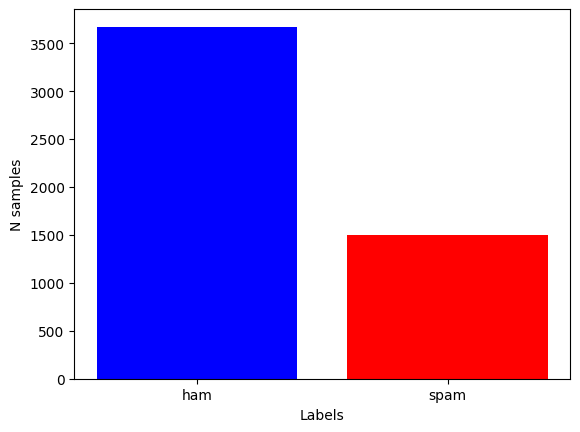

In [ ]:
import matplotlib.pyplot as plt
colors = ['blue', 'red']
plt.bar(dataset['label'].unique(), [dataset['label'].value_counts()[0], dataset['label'].value_counts()[1]], color=colors)
plt.xlabel('Labels')
plt.ylabel('N samples')
plt.show()

With the following libraries, I create the *data_cleaner* function in order to prepare the text for the following steps.

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
import spacy
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In particular:
*   words are put in lowercase
*   punctuation is removed
*   words are lemmatized
*   stopwords are removed (the words 'from', 'subject', 're', commonly found in emails, are added to the stopwords list )
*   numbers are removed

In [ ]:
english_stopwords = stopwords.words('english')
english_stopwords.extend(['from', 'subject', 're'])
nlp = spacy.load('en_core_web_sm')
punctuation = set(string.punctuation)

def data_cleaner(sentence):
    sentence = sentence.lower()
    for c in string.punctuation:
        sentence = sentence.replace(c, " ")
    document = nlp(sentence)
    sentence = ' '.join(token.lemma_ for token in document)
    sentence = ' '.join(word for word in sentence.split() if word not in english_stopwords)
    sentence = re.sub('\d', '', sentence)
    return sentence

With this function I "clean" every email sample of the dataset, which is put in a new dataset *df_cleaned* along with its *label_num*.

In [ ]:
df_cleaned = pd.DataFrame(columns=['text', 'label'])
df_cleaned['text'] = dataset['text'].apply(data_cleaner)
df_cleaned['label'] = dataset['label_num']
df_cleaned

,text,label
0,enron methanol meter follow note I give monda...,0
1,hpl nom january see attached file hplnol xl...,0
2,neon retreat ho ho ho around wonderful time ye...,0
3,photoshop window office cheap main trending ab...,1
4,indian spring deal book teco pvr revenue under...,0
...,...,...
5166,put ft transport volume decrease contract ...,0
5167,follow nom hpl take extra mmcf weekend try...,0
5168,calpine daily gas nomination julie I mention e...,0
5169,industrial worksheet august activity attach w...,0


Let's compare the first sample, before and after the clean function

In [ ]:
dataset['text'].iloc[0]

"Subject: enron methanol ; meter # : 988291\nthis is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary\nflow data provided by daren } .\nplease override pop ' s daily volume { presently zero } to reflect daily\nactivity you can obtain from gas control .\nthis change is needed asap for economics purposes ."

In [ ]:
df_cleaned['text'].iloc[0]

' enron methanol meter  follow note I give monday    preliminary flow datum provide daren please override pop daily volume presently zero reflect daily activity obtain gas control change need asap economic purpose'

In order to train a classification model, the texts need to be vectorized.
To do so I use *CountVectorizer*, that creates a token array for each sample of the dataset.

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer()
X = cvec.fit_transform(df_cleaned['text']).toarray()
y = df_cleaned['label'].values

In [ ]:
X.shape

(5171, 41396)

In [ ]:
y.shape

(5171,)

As mentioned earlier, the dataset is significantly **imbalanced**. Therefore I use *SMOTE* in order to balance the dataset. *SMOTE* creates new synthetic *spam* samples (the minority category) needed to perfectly balance (50-50) the dataset.

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)
X_resampled, y_resampled = smote.fit_resample(X, y)

The dataset now has 7.344 samples, perfectly balanced between *ham* and *spam*, both with 3.672 samples.

In [ ]:
X_resampled.shape

(7344, 41396)

In [ ]:
y_resampled.shape

(7344,)

In [ ]:
spam_samples = np.sum(y_resampled)
ham_samples = y_resampled.shape[0]-np.sum(y_resampled)
print('Number of ham samples: ',ham_samples)
print('Number of spam samples: ',spam_samples)

Number of ham samples:  3672
Number of spam samples:  3672


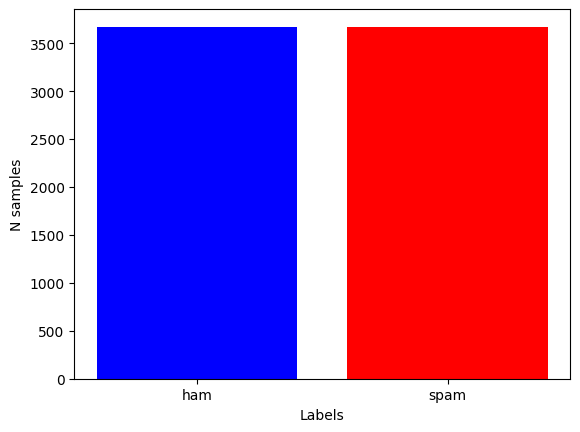

In [ ]:
plt.bar(dataset['label'].unique(), [ham_samples, spam_samples], color=colors)
plt.xlabel('Labels')
plt.ylabel('N samples')
plt.show()

I split the balanced dataset in train and test sets.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=0)

## **Classification model**

In order to classify emails I define the following neural netwotk model with Tensorflow.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
model_nn = Sequential()
model_nn.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
model_nn.add(Dropout(0.5))
model_nn.add(Dense(64, activation='relu'))
model_nn.add(Dense(1, activation='sigmoid'))
model_nn.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 128)                 │       5,298,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,307,137 (20.25 MB)

 Trainable params: 5,307,137 (20.25 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
callback_es = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=2, verbose=1, restore_best_weights=True)

In [ ]:
model_nn.fit(X_train, y_train, epochs=20, validation_split=0.1, shuffle=True, callbacks=[callback_es])

Epoch 1/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.9257 - loss: 0.3229 - val_accuracy: 0.9881 - val_loss: 0.0666
Epoch 2/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9941 - loss: 0.0233 - val_accuracy: 0.9898 - val_loss: 0.0381
Epoch 3/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9978 - loss: 0.0103 - val_accuracy: 0.9898 - val_loss: 0.0357
Epoch 4/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9991 - loss: 0.0038 - val_accuracy: 0.9915 - val_loss: 0.0430
Epoch 5/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9998 - loss: 0.0018 - val_accuracy: 0.9915 - val_loss: 0.0429
Epoch 6/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9999 - loss: 0.0014 - val_accuracy: 0.9915 - val_loss: 0.0523
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 4.


In [ ]:
model_nn.evaluate(X_test, y_test)

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9858 - loss: 0.1247


[0.10401508957147598, 0.9870660305023193]

The fitted model performs really well in classifying spam, in both train and validation sets, with a 99% accuracy.
The accuracy is basically the same on the test set.

In order to furtherly test the model, I took 1 *ham* and 1 *spam* examples from another dataset (https://www.kaggle.com/datasets/jackksoncsie/spam-email-dataset) and use the model to predict wether it is *ham* or *spam*.
The model classifies correctly these samples.

In [ ]:
spam_sentence_test = 'Subject: naturally irresistible your corporate identity  lt is really hard to recollect a company : the  market is full of suqgestions and the information isoverwhelminq ; but a good  catchy logo , stylish statlonery and outstanding website  will make the task much easier .  we do not promise that havinq ordered a iogo your  company will automaticaily become a world ieader : it isguite ciear that  without good products , effective business organization and practicable aim it  will be hotat nowadays market ; but we do promise that your marketing efforts  will become much more effective . here is the list of clear  benefits : creativeness : hand - made , original logos , specially done  to reflect your distinctive company image . convenience : logo and stationery  are provided in all formats ; easy - to - use content management system letsyou  change your website content and even its structure . promptness : you  will see logo drafts within three business days . affordability : your  marketing break - through shouldnt make gaps in your budget . 100 % satisfaction  guaranteed : we provide unlimited amount of changes with no extra fees for you to  be surethat you will love the result of this collaboration . have a look at our  portfolio'

In [ ]:
ham_sentence_test = 'Subject: re : london contact number  hi anita ,  how are you ? i arrived yesterday late morning from the london gatwick airport . due to rush hour traffic , etc . it took a while to get into the city to the hotel .  also , due to may day ( may lst ) protests / riots , etc . , the hotel management strongly recommended that we remain in the hotel .  however , i am in the office today . i can be reached via email or via telephone at 44 ( 0 ) 207 783 5647 .  take care ,  iris  - - - - - original message - - - - -  from : dupont , anita  sent : tuesday , may 01 , 2001 5 : 23 pm  to : mmumford @ enron . com  cc : mack , iris ; crenshaw , shirley  subject : i . m . mack 30 apr - 15 may * * plse review for accuracy * * agent ce / ce booking ref x 7 w 882 mack / iris eb 1972 enron corp  importance : high  see iris itinerary below . i thought her initial plan was to land this morning and come in to enron house in early afternoon . see itinerary for phone number of hotel . let me know if i can help in any  other way . thanks . anita  service date from to depart arrive  continental airlines 30 apr houston tx london gatwick 350 p 655 a  co 34 j mon g . bush iah gatwick 01 may  terminal dom terminal s  dinner / snack non stop  reservation confirmed 9 : 05 duration  vegetarian meal , non - dairy confirmed  aircraft : boeing 777 - 200 / 300  hotel 30 apr athenaeum hotel and apartments  11 may 116 piccadilly  london england , wlv obj  united kingdom  telephone : 44 - ( 0 ) - 207 - 499 - 3464  fax : 44 - ( 0 ) - 207 - 493 - 1860  confirmation : claire 25 apr  rate : rac gbp 270 . 00 per night  guarantee given  prereg actual arr lmay 655 am apartment  to avoid billing cancel by 6 pm 24 hrs prior  continental airlines 11 may london gatwick houston tx 1200 n 415 p  co 5 j fri gatwick g . bush iah  terminal s terminal dom  lunch / snack non stop  reservation confirmed 10 : 15 duration  vegetarian meal , non - dairy confirmed  aircraft : boeing 777 - 200 / 300'

In [ ]:
model_nn.predict(cvec.transform([data_cleaner(spam_sentence_test)]).toarray())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


array([[0.9999999]], dtype=float32)

In [ ]:
model_nn.predict(cvec.transform([data_cleaner(ham_sentence_test)]).toarray())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


array([[2.8092717e-10]], dtype=float32)

In [ ]:
#model_nn.save("/content/drive/MyDrive/Colab Notebooks/08 - Natural Language Processing/Progetto/model_nn.keras")

In [ ]:
#model_nn = load_model("/content/drive/MyDrive/Colab Notebooks/08 - Natural Language Processing/Progetto/model_nn.keras")

## **Topic modelling**

In order to find the main topics of the spam portion of the dataset I use the LDA model, after some preprocessing steps.

At first, I save all the original spam samples in a more convenient dataframe *df_spam*.

In [ ]:
df_spam = df_cleaned[df_cleaned['label']==1]
df_spam.shape

(1499, 2)

As the emails texts have already been cleaned, there are only a few steps required:
1.   split each email in order to obtain a list of words
2.   removing words shorter than 5 letters, as they are probably not very meaningful

In [ ]:
split_email = [email.split() for email in df_spam['text']]
data_words = []
for email in split_email:
  data_words.append([word for word in email if len(word) >=5])

I obtain the list *data_words*, where each item is a list of preprocessed (and at least 5 letter long) words corresponding to a spam email.

In [ ]:
#data_words

With the *Gensim* library, I create a word dictionary and tokenize the texts in order to use the *LDA* model.

In [ ]:
import gensim.corpora as corpora
word_dict = corpora.Dictionary(data_words)
corpus = [word_dict.doc2bow(email) for email in data_words]

I build the LDA model, and find the most outlined results with 3 topics and 8 passes.

In [ ]:
import gensim
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=word_dict,
                                       num_topics=3,
                                       passes = 8)

In [ ]:
#lda_model.save("/content/drive/MyDrive/Colab Notebooks/08 - Natural Language Processing/Progetto/lda_model")
#from gensim.models.ldamodel import LdaModel
#lda_model = LdaModel.load("/content/drive/MyDrive/Colab Notebooks/08 - Natural Language Processing/Progetto/lda_model")

In [ ]:
from pprint import pprint
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.010*"height" + 0.008*"width" + 0.007*"price" + 0.006*"align" + '
  '0.005*"color" + 0.005*"border" + 0.004*"adobe" + 0.004*"window" + '
  '0.004*"microsoft" + 0.004*"professional"'),
 (1,
  '0.004*"online" + 0.004*"viagra" + 0.004*"please" + 0.004*"cialis" + '
  '0.004*"order" + 0.003*"prescription" + 0.003*"thank" + 0.002*"account" + '
  '0.002*"click" + 0.002*"email"'),
 (2,
  '0.012*"company" + 0.007*"statement" + 0.007*"information" + 0.006*"stock" + '
  '0.006*"price" + 0.005*"email" + 0.005*"security" + 0.004*"please" + '
  '0.004*"investment" + 0.004*"report"')]


The 3 main topics found in the spam emails, according to my interpretation of the LDA results, are:

1) 0: *software*

2) 1: *male sexual performances enhancement*

3) 2: *finance and investments*




In order to assign to each *spam* email its topic, I define the following function that extract the "dominant" topic from a given text and iterate it on every *spam* email.

In [ ]:
def max_topic(document_topics_probs):
  topics_probs = [item[1] for item in document_topics_probs]
  return topics_probs.index(max(topics_probs))

topic_list = []
for email in corpus:
  email_topics_probs = lda_model.get_document_topics(email)
  topic_list.append(max_topic(email_topics_probs))

I check that the *topic_list* has the same size as the spam samples and that the topics are actually 3 (0, 1, 2).

In [ ]:
len(topic_list)

1499

In [ ]:
set(topic_list)

{0, 1, 2}

Eventually, I create a specific dataframe with spam samples and their topic.

In [ ]:
df_spam_topics = df_spam.copy()
df_spam_topics['topic'] = topic_list
df_spam_topics

,text,label,topic
3,photoshop window office cheap main trending ab...,1,0
7,look medication good source difficult make mat...,1,1
10,vocable rnd word asceticism vcsc brand new sto...,1,0
11,report wffur attion brom est inst siupie pgs...,1,1
13,vic odin n ow berne hotbox carnal bride cutwor...,1,0
...,...,...,...
5159,picture streamline denizen ajar chase heavens ...,1,0
5161,penny stock time nomad international inc ndin ...,1,0
5162,anomaly boy uosda apaprove mledms heure crack...,1,0
5164,slutty milf want meet take ilaa liqaa,1,0



According to the *LDA model*, most of the *spam* emails deal with software (764), while 478 samples are about male sexual performances. 257 *spam* emails talk about finance.

In [ ]:
df_spam_topics['topic'].value_counts()

,count
topic,
0,764
1,478
2,257


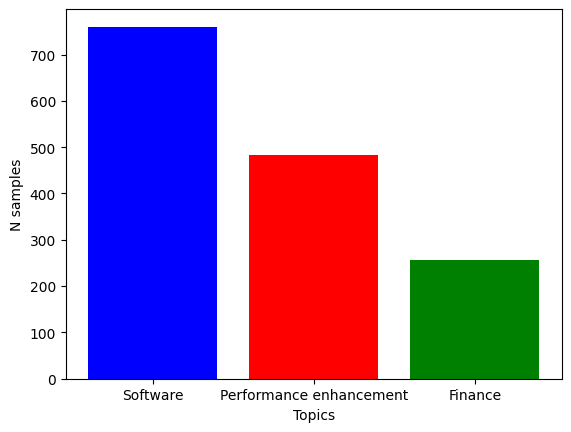

In [ ]:
colors = ['blue', 'red', 'green']
plt.bar(['Software', 'Performance enhancement', 'Finance'], [df_spam_topics['topic'].value_counts()[0], df_spam_topics['topic'].value_counts()[1], df_spam_topics['topic'].value_counts()[2]], color=colors)
plt.xlabel('Topics')
plt.ylabel('N samples')
plt.show()

## **Semantic similarity**

In order to calculate the semantic similarity between the topics, I need to use a *Gensim* pre-trained model capable of transforming words in ***embedding***. The word embeddings will be used later to calculate an average embedding vector for each topic.

In [ ]:
import gensim.downloader
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-300')

[==================================================] 100.0% 376.1/376.1MB downloaded


For a more convenient elaboration of the embeddings and the vectors, I create another dataframe, with the *spam* emails already pre-processed for Topic Modeling and their corresponding topic.

In [ ]:
df_spam_emb = pd.DataFrame(columns=['split_email', 'topic'])
df_spam_emb['split_email'] = data_words
df_spam_emb['topic'] = list(df_spam_topics['topic'])
df_spam_emb.head()

,split_email,topic
0,"[photoshop, window, office, cheap, trending, a...",0
1,"[medication, source, difficult, material, cond...",1
2,"[vocable, asceticism, brand, stock, attention,...",0
3,"[report, wffur, attion, siupie, asently, presy...",1
4,"[berne, hotbox, carnal, bride, cutworm, dyadic...",0


As the goal is to measure the distance between the **average vectors** of each topic, I report below a function that estimates an average vector by calculating the **mean** of every word embedding of a given text.

Using the *key_to_index* method of the *Gensim* model saved in *glove_vectors* I can transform every word in an embedding and add it incrementally. While returning the result, the mean is calculated considering also the possible words that can not be embedded by the model.

The arrays length (300) is defined by the selected model.

In [ ]:
def avg_vector(text):
    to_remove = 0
    vector = np.zeros(300)
    for word in text:
        if word in glove_vectors.key_to_index.keys():
            vector += glove_vectors.get_vector(word)
        else:
            to_remove += 1
    if len(text)== to_remove:
        return np.zeros(300)

    return vector/(len(text)-to_remove)

The function below creates a list of words for a given dataframe (like the last one created, *df_spam_emb*) and topic index.
Every word that belongs to a spam email of the given topic index is collected in a single list, creating a sort of "topic dictionary".

In [ ]:
def create_topic_word_list(df, topic):
  topic_word_list = []
  for email in df[df['topic']==topic]['split_email']:
    topic_word_list += email
  return topic_word_list

Then I iterate the *create_topic_word_list* function for each topic index, in order to get a list for each topic (saved in the *word_list_by_topics* list).

In [ ]:
word_list_by_topics = []
for topic in set(topic_list):
  word_list_by_topics.append(create_topic_word_list(df_spam_emb, topic))

Having 3 lists of words for each topic, I can finally calculate the average vector for each topic.

In [ ]:
topic_vectors = []
for word_list in word_list_by_topics:
    topic_vectors.append(avg_vector(word_list))

In order to calculate the similarity between topics, I need to import the *spatial* module from *scipy* library, as it is measured by the *cosine distance*.

In [ ]:
from scipy import spatial

In [ ]:
print('Distance between software (0) and male sexual performances enhancement (1)')
print(round(1 - spatial.distance.cosine(topic_vectors[0], topic_vectors[1]), 2))

Distance between software (0) and male sexual performances enhancement (1)
0.99


In [ ]:
print('Distance between software (0) and finance (2)')
print(round(1 - spatial.distance.cosine(topic_vectors[0], topic_vectors[2]), 2))

Distance between software (0) and finance (2)
0.98


In [ ]:
print('Distance between finance (2) and male sexual performances enhancement (1)')
print(round(1 - spatial.distance.cosine(topic_vectors[2], topic_vectors[1]), 2))

Distance between finance (2) and male sexual performances enhancement (1)
0.99


The measures of the distances between topics reach very high level, meaning that the topics, according to this model, are very similar.

## **Named Entity Recognition - Organizations**

In order to extract from the *ham* emails the organizations' names, I will use the *Named Entity Recognition (**NER**)* functionalities of the *spacy* library models, already imported at the beginning of this notebook.

I define a different data cleaning function to prepare the *ham* emails to *NER*. Compared to the one used so far in this notebook, this one does not *lemmatize* the words, as they need to be read by the model in their original form.

In [ ]:
def data_cleaner_ner(sentence):
  sentence = sentence.lower()
  for c in string.punctuation:
    sentence = sentence.replace(c, " ")
  sentence = ' '.join(word for word in sentence.split() if word not in english_stopwords)
  sentence = re.sub('\d', '', sentence)
  return sentence

The ham emails texts are then cleaned and saved in a list.

In [ ]:
ham_list = list(dataset['text'].apply(data_cleaner_ner))

Using *nlp* and the *ent_type_* method iterating on every *ham* email, I can save the words recognized as Organization (*ORG*) in a list.

More than 4.000 words (printed below) have been recognized as Organizations.

In [ ]:
org_list = []
for email in ham_list:
  doc = nlp(email)
  for token in doc:
    if str(token.ent_type_) == 'ORG':
      org_list.append(str(token))

In [ ]:
len(set(org_list))

4077

In [ ]:
set(org_list)

{'mandey',
 'mahayana',
 'abruptness',
 'carte',
 'lavorato',
 'frankfurt',
 'desist',
 'strawflower',
 'spot',
 'portland',
 'resource',
 'plr',
 'per',
 'beautician',
 'welcome',
 'slingshot',
 'complimentary',
 'ldp',
 'woodward',
 'deliberate',
 'ics',
 'dmi',
 'johannesburg',
 'nokia',
 'apollonian',
 'entertainment',
 'revolutionizing',
 'pendant',
 'metro',
 'florist',
 'cia',
 'ichneumon',
 'gift',
 'sordo',
 'snapshot',
 'finance',
 'regency',
 'spoke',
 'burnell',
 'hou',
 'cooper',
 'spmbsxz',
 'part',
 'madsen',
 'ford',
 'ihpw',
 'forma',
 'carey',
 'hope',
 'portugal',
 'cocklebur',
 'sub',
 'accounting',
 'greenery',
 'planning',
 'wheaton',
 'newsome',
 'negotiates',
 'baptist',
 'nathan',
 'fioric',
 'lithospheric',
 'announcements',
 'onl',
 'sherri',
 'dru',
 'dtoi',
 'cowboy',
 'divalent',
 'pf',
 'iejczcus',
 'son',
 'tus',
 'whiting',
 'gener',
 'wvbyxtvff',
 'ingersoll',
 'arm',
 'points',
 'workperson',
 'saxophone',
 'ky',
 'corpsman',
 'jpg',
 'pbs',
 'airline